# Convert

In [2]:
from model import create_model
from utils import load_weights

In [ ]:
nn4_small2 = create_model()
nn4_small2_weights = load_weights()

In [ ]:
for name, w in nn4_small2_weights.items():
    if nn4_small2.get_layer(name) != None:
        nn4_small2.get_layer(name).set_weights(w)

nn4_small2.save_weights('weights/nn4.small2.v1.h5')

# Download Landmarks

In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

# Load pretrained model

In [4]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('models/nn4.small2.v1.h5')

# Load data

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
from align import AlignDlib
import numpy as np
%matplotlib inline

In [6]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [14]:
f=open("clean.csv", "r", encoding = "utf-8")
reader = csv.reader(f)
count=0
for row in reader:
    image_path="./"+row[3]
    jc_orig = cv2.imread(image_path)
    if jc_orig is None:
        count+=1
count

83

In [15]:
f=open("clean.csv", "r", encoding = "utf-8")
reader = csv.reader(f)
labels=[]
paths=[]
for row in reader:
    image_path="./"+row[3]
    if cv2.imread(image_path) is not None:
        labels.append(row[2])
        paths.append(row[3])
labels=[int(row)-1 for row in labels]
print(len(labels),len(paths))

3317 3317


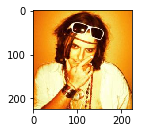

In [17]:
image_path="./profile pics/60147.jpeg"
jc_orig = load_image(image_path)
plt.subplot(131)
plt.imshow(jc_orig)

In [16]:

alignment = AlignDlib('models/landmarks.dat')
image_path="./profile pics/60147.jpeg"
jc_orig = load_image(image_path)
# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)
print(bb)

None


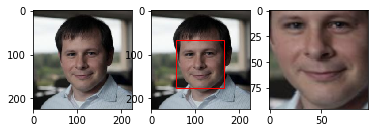

In [32]:
image_path="./profile pics/60170.jpeg"
jc_orig = load_image(image_path)
bb = alignment.getLargestFaceBoundingBox(jc_orig)
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
plt.subplot(131)
plt.imshow(jc_orig)
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
plt.subplot(133)
plt.imshow(jc_aligned);

In [18]:
cleaned_labels=[]
cleaned_paths=[]

for i in range(len(paths)):
    image_path="./"+paths[i]
    #print(row)
    jc_orig = load_image(image_path)
    bb = alignment.getLargestFaceBoundingBox(jc_orig)
    if bb is not None:
        cleaned_labels.append(labels[i])
        cleaned_paths.append(paths[i])
        
print(len(cleaned_labels),len(cleaned_paths))

1698 1698


In [33]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Embedding vectors

In [35]:
train_paths=cleaned_paths[3:]
train_labels=cleaned_labels[3:]
print(len(train_paths),len(train_labels))

1695 1695


In [36]:
data_X=np.zeros((len(train_paths),128))
for i in range(len(data_X)):
    img = load_image(train_paths[i])
    img = align_image(img)
    img = (img / 255.).astype(np.float32)
    data_X[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

In [37]:
data_X[0]

array([ 0.03346599,  0.2210169 ,  0.14910699,  0.11792912, -0.02995916,
        0.13238256,  0.0271141 , -0.0237413 ,  0.05584815, -0.0602168 ,
        0.1204296 , -0.04568419, -0.08841413, -0.05991087,  0.04029769,
       -0.14212362,  0.04171156,  0.16734231, -0.05770964, -0.10580627,
        0.08958386,  0.0128533 , -0.07692038,  0.10456799,  0.16981341,
       -0.24040236, -0.07137568,  0.08627963,  0.02378809,  0.05285526,
        0.11449791, -0.135851  , -0.03420183,  0.07168558,  0.08155046,
       -0.03604905, -0.01497219, -0.10632659, -0.0039277 , -0.00796324,
        0.02531341,  0.0308673 ,  0.04604797,  0.04639255, -0.0139434 ,
       -0.19657464,  0.00817014, -0.06092031, -0.0682314 ,  0.02335902,
        0.08271854,  0.07183199, -0.07576281, -0.02831316, -0.06986029,
        0.08358666, -0.14944002,  0.03609849, -0.02338895, -0.08089339,
       -0.06138424, -0.02062934,  0.03072236, -0.16452077,  0.02247197,
        0.02784205,  0.08865496, -0.18200192, -0.21342742,  0.17

In [58]:
train_labels=np.array(train_labels)

# Classifier

In [48]:
from sklearn import metrics
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras import models
from keras import layers
from sklearn.model_selection import KFold

In [60]:
network = models.Sequential()  
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(4, activation='softmax')) 

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [49]:
kf = KFold(n_splits=5, shuffle=False, random_state=1)

In [63]:
y_predicted_overall = None
y_test_overall = None
for train_index, test_index in kf.split(data_X):
    X_train, X_test = data_X[train_index], data_X[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    y_train=to_categorical(y_train,4)
    network.fit(X_train, y_train, epochs=20)
    y_pred_class = network.predict(X_test)
    y_predicted=np.argmax(y_pred_class,axis=1)
    if y_predicted_overall is None:
        y_predicted_overall = y_predicted
        y_test_overall = y_test
    else: 
        y_predicted_overall = np.concatenate([y_predicted_overall, y_predicted])
        y_test_overall = np.concatenate([y_test_overall, y_test])

Epoch 1/20
1356/1356 [==============================] - 1s 867us/step - loss: 0.7562 - acc: 0.8134
Epoch 2/20
1356/1356 [==============================] - 0s 138us/step - loss: 0.4710 - acc: 0.8643
Epoch 3/20
1356/1356 [==============================] - 0s 152us/step - loss: 0.4358 - acc: 0.8746
Epoch 4/20
1356/1356 [==============================] - 0s 171us/step - loss: 0.4222 - acc: 0.8754
Epoch 5/20
1356/1356 [==============================] - 0s 133us/step - loss: 0.4108 - acc: 0.8739
Epoch 6/20
1356/1356 [==============================] - 0s 153us/step - loss: 0.4021 - acc: 0.8746
Epoch 7/20
1356/1356 [==============================] - 0s 126us/step - loss: 0.3970 - acc: 0.8746
Epoch 8/20
1356/1356 [==============================] - 0s 132us/step - loss: 0.3903 - acc: 0.8768
Epoch 9/20
1356/1356 [==============================] - 0s 114us/step - loss: 0.3843 - acc: 0.8754
Epoch 10/20
1356/1356 [==============================] - 0s 138us/step - loss: 0.3781 - acc: 0.8761
Epoch 11/

1356/1356 [==============================] - 0s 140us/step - loss: 0.1213 - acc: 0.9594
Epoch 4/20
1356/1356 [==============================] - 0s 149us/step - loss: 0.1150 - acc: 0.9646
Epoch 5/20
1356/1356 [==============================] - 0s 149us/step - loss: 0.1068 - acc: 0.9653
Epoch 6/20
1356/1356 [==============================] - 0s 152us/step - loss: 0.1015 - acc: 0.9727
Epoch 7/20
1356/1356 [==============================] - 0s 183us/step - loss: 0.0980 - acc: 0.9727
Epoch 8/20
1356/1356 [==============================] - 0s 152us/step - loss: 0.0950 - acc: 0.9727
Epoch 9/20
1356/1356 [==============================] - 0s 112us/step - loss: 0.0866 - acc: 0.9742
Epoch 10/20
1356/1356 [==============================] - 0s 105us/step - loss: 0.0846 - acc: 0.9771
Epoch 11/20
1356/1356 [==============================] - 0s 145us/step - loss: 0.0808 - acc: 0.9779
Epoch 12/20
1356/1356 [==============================] - 0s 125us/step - loss: 0.0759 - acc: 0.9764
Epoch 13/20
1356/1

In [64]:
metrics.accuracy_score(y_test_overall, y_predicted_overall)

0.8991150442477877

In [65]:
print(classification_report(y_true=y_test_overall,y_pred=y_predicted_overall))

             precision    recall  f1-score   support

          0       0.77      0.78      0.78       137
          1       0.60      0.34      0.43        91
          2       0.54      0.28      0.37        53
          3       0.93      0.97      0.95      1414

avg / total       0.89      0.90      0.89      1695

